<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


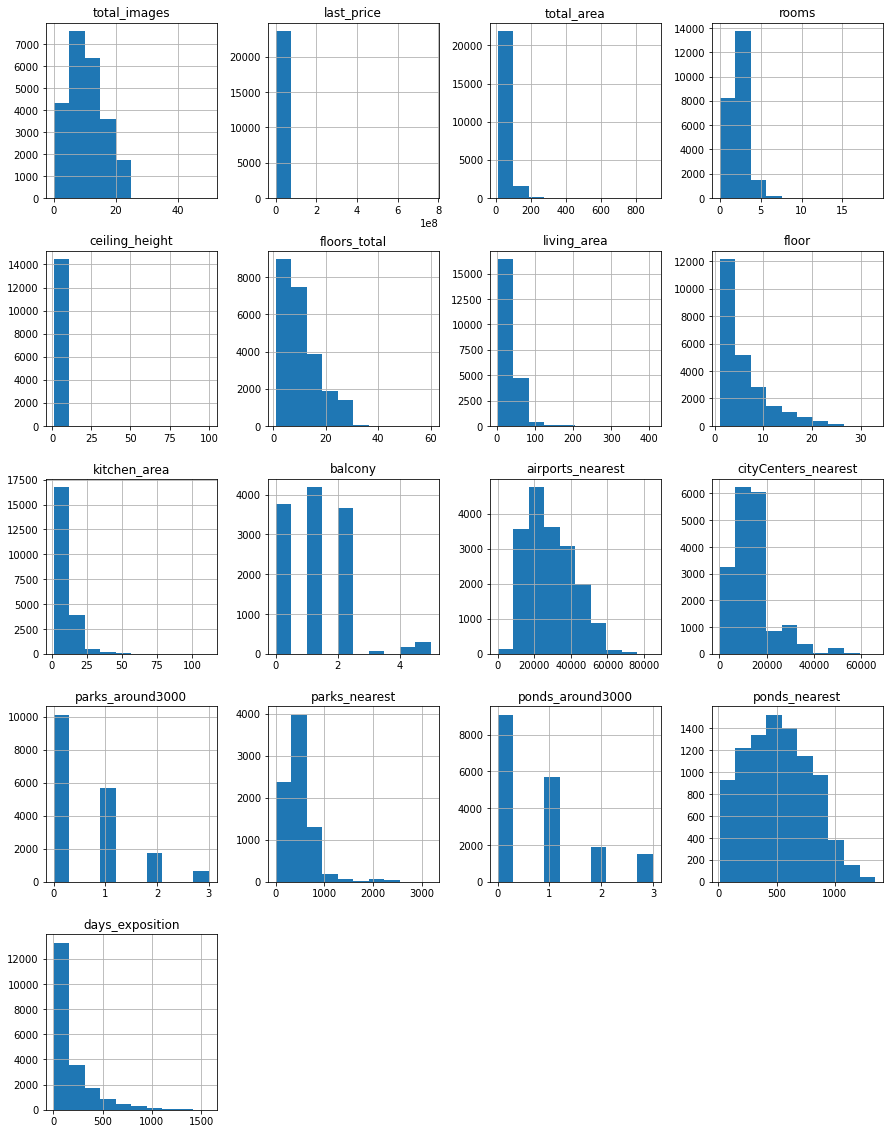

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

df.info()
display(df.head())
df.hist(figsize=(15,20));

In [2]:
# check
# пропущенные значения бары

# check
def pass_value_barh(df):
    (
        (df.isna().mean()*100)
        .to_frame()
        .rename(columns = {0:'space'})
        .query('space > 0')
        .sort_values(by = 'space', ascending = True)
        .plot(kind= 'barh', figsize=(19,6), rot = -5, legend = False, fontsize = 16)
        .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
    );    

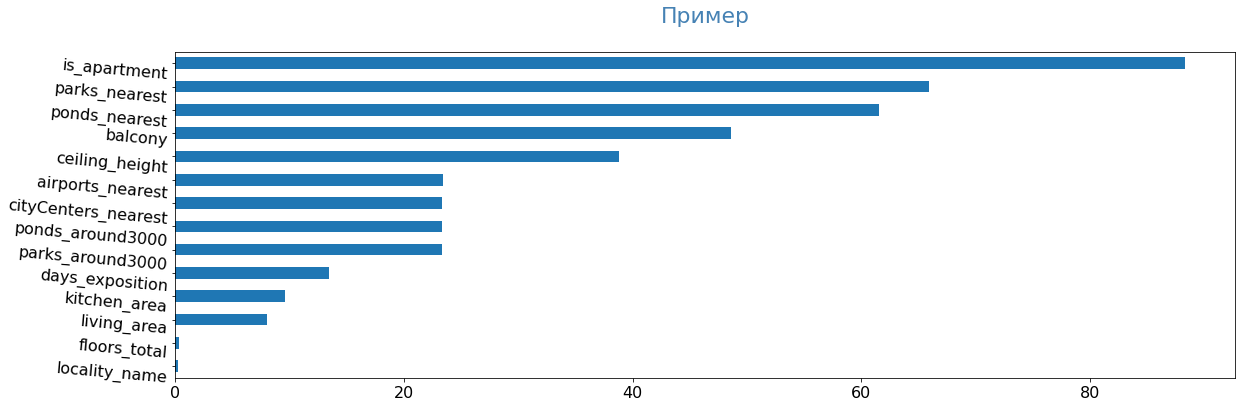

In [3]:
pass_value_barh(df)

### Предобработка данных

1. Заполняю пропущенные значения значением 0 и преобразую стодбецы из float в int:
- число балконов,
- число парков в 3т.км,
- число водоемов в радиусе 3 т.км

2. Меняю пропущеные значения в столбце is_apartment на False и тип данных на bool так как столбец имеет логическое выражение
3. Устранил неявные дубликаты в столбце locality_name: поменял посЁлок на посЕлок. Было 365 осталос 331
4. Мучения с аномалиями:
- Считаю что в столбце ceiling_heoght есть явные выбросы (например высота потолка 100 метров). Через цикл переписал значения выше 20 метров поделив их на 100, так что высота 32 метра стала 3,2 метра.
- Столбец kitchen_area содержит довольно большие площади кухни (112 м2), что похоже на аномалию и меньше чем моя квартирка, но при проверке выяснилось что у таких наблюдений общая площадь гораздо больше. Так что считаю что в столбце нет аномалий.


In [4]:
df['balcony'] = df['balcony'].fillna(0).astype('int')
df['floors_total'] = df['floors_total'].fillna(0).astype('int')
df['parks_around3000'] = df['parks_around3000'].fillna(0).astype('int')
df['ponds_around3000'] = df['ponds_around3000'].fillna(0).astype('int')
df['last_price'] = df['last_price'].astype('int')
df['is_apartment'] = df['is_apartment'].fillna(False)
#df.info()
#print(df['is_apartment'].unique())

df['locality_name'] = df['locality_name'].str.replace('посёлок','поселок')

#print(df['ceiling_height'].sort_values(ascending=False).head(10))
#print(df['ceiling_height'].describe())
df.loc[df['ceiling_height'] > 20, 'ceiling_height'] = df['ceiling_height'] / 10

#делаю срез данных для rooms
df['to_much_rooms'] = df['rooms'] > 9
data_rooms = df.query('to_much_rooms == False') #положил в переменную все объявления где количество комнат меньше 10

#делаю срез для общей площади
df['too_much_area'] = df['total_area'] > 120
print(df['too_much_area'].mean()) # квартир с площадью более 120 метров 4% от всех наблюдейний, исключаю такие
data_area = df.query('too_much_area == False')

#делаю срез для высоты потолков, убираю 1 метровые и более 10 метров
data_ceiling = df.query('1 < ceiling_height < 10') # собрал все объявления где потолки более менее похожи на реальные

#делаю срез для стоимости квартир
df['too_much_price'] = df['last_price'] > 16000000
print(df['too_much_price'].mean()) # исключаю квартиры стоимостью более 16 млн рублей
data_price = df.query('too_much_price == False')
#print(data_price.sort_values(by='total_area', ascending=False))

#делаю срез для жилой площади
df['too_much_living'] = df['living_area'] > 70
print(df['too_much_living'].mean()) # исключаю квартиры с жилой площадью более 70 метров
data_living_area = df.query('too_much_living == False')

#делаю срез для кухонной площади
df['too_much_kitchen'] = df['kitchen_area'] > 20
print(df['too_much_kitchen'].mean()) # исключаю квартиры с кухонной площадью более 20 метров
data_kitchen_area = df.query('too_much_kitchen == False')

#делаю срез для количества этажей в доме
df['too_much_floors'] = df['floors_total'] > 24
print(df['too_much_floors'].mean()) # исключаю объекты где количество этажей превышает 24
data_floors = df.query('too_much_floors == False')


0.044812017384699775
0.04493860500443057
0.0431663783281995
0.0431663783281995
0.05979155238617663


<div class="alert alert-info">
<b>Удаляю аномалии</b></font>

#1 Количкство комнат. Из графика видно, что выбросы начинаются от 7 комнат. Тогда считаю их аномалиями и удаляю.

#2 Общая площадь содержит очень много выбросов, удяляю те, где более 120 метров.

#3 Высота потолков тоже изобилует выбросами, причем в обе стороны. Считаю аномалиями более 3 и менее 2 метров высоту потолков.

#4 Стоимость квартиры более 16 млн тоже считаю аномалией.

#5 Дома выше 30 этажей тоже редкость для Питера


Прости, что спрашиваю, но это нормально когда столько много данных удаляются из датасета? Получается я почти 2500 строк удалил из-за того, что значения были слишком большие или маленькие.

In [5]:
#df.boxplot(column='rooms')
#df.boxplot(column='total_area')
#df.boxplot(column='ceiling_height')
#df.boxplot(column='last_price')
#df.boxplot(column='floors_total')

print(df.shape)
df = df.drop(df[df['rooms'] > 7].index)
print(df.shape)
df = df.drop(df[df['total_area'] > 120].index)
print(df.shape)
df = df.drop(df[df['ceiling_height'] > 3].index)
df = df.drop(df[df['ceiling_height'] < 2].index)
print(df.shape)
df = df.drop(df[df['last_price'] > 16000000].index)
print(df.shape)
df = df.drop(df[df['floors_total'] > 30].index)
print(df.shape)


(23699, 28)
(23668, 28)
(22637, 28)
(21520, 28)
(21260, 28)
(21229, 28)


In [6]:
# check
df_check = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') 
df_check.info()
df_isna = df_check.query('airports_nearest.isna() | airports_nearest < 60000')
df_isna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [7]:
# check
df_check = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') 
df_check.info()
df_isna = df_check[(df_check ['airports_nearest'] < 60000) | (df_check ['airports_nearest'].isna()) ]

df_isna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [8]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных показателях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    df[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area', 'floor',
       'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"21,229.00","21,229.00","12,502.00","18,652.00","21,229.00","19,528.00","19,154.00","21,229.00","21,229.00"
min,0.00,12.00,2.00,1.00,"12,190.00",2.00,1.30,1.00,0.00
max,7.00,120.00,3.00,"1,580.00","16,000,000.00",100.00,64.00,27.00,29.00


In [9]:
# check
df.rooms.value_counts().to_frame()

,rooms
1,7880
2,7419
3,4975
4,692
0,187
5,68
6,7
7,1


Отчистил датасет от аномальных значений.
1. срез данных для rooms
data_rooms - положил в переменную все объявления где количество комнат меньше 10

2. срез для общей площади
data_area - квартир с площадью более 120 метров 4% от всех наблюдейний, исключаю такие

3. срез для высоты потолков, убираю 1 метровые и более 10 метров
data_ceiling - собрал все объявления, где потолки похожи на реальные

4. срез для стоимости квартир
data_price - исключаю квартиры стоимостью более 16 млн рублей

5. срез для жилой площади
data_living_area - исключаю квартиры с жилой площадью более 70 метров

6. срез для кухонной площади
data_kitchen_area - исключаю квартиры с кухонной площадью более 20 метров

7. срез для количества этажей в доме
data_floors - исключаю объекты где количество этажей превышает 24

In [10]:
# check
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21229 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          21229 non-null  int64  
 1   last_price            21229 non-null  int64  
 2   total_area            21229 non-null  float64
 3   first_day_exposition  21229 non-null  object 
 4   rooms                 21229 non-null  int64  
 5   ceiling_height        12502 non-null  float64
 6   floors_total          21229 non-null  int64  
 7   living_area           19528 non-null  float64
 8   floor                 21229 non-null  int64  
 9   is_apartment          21229 non-null  bool   
 10  studio                21229 non-null  bool   
 11  open_plan             21229 non-null  bool   
 12  kitchen_area          19154 non-null  float64
 13  balcony               21229 non-null  int64  
 14  locality_name         21188 non-null  object 
 15  airports_nearest   

### Посчитайте и добавьте в таблицу новые столбцы

In [11]:
df['price_per_meter'] = (df['last_price'] / df['total_area']).astype('int')
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%d')
df['weekday_expo'] = df['first_day_exposition'].dt.weekday
df['month_expo'] = df['first_day_exposition'].dt.month
df['year_expo'] = df['first_day_exposition'].dt.year

def floor_type (floor_number):
    if floor_number['floor'] <= 1:
        return 'Первый'
    elif floor_number['floor'] == floor_number['floors_total']:
        return 'Последний'
    else: return 'Другой'
df['floor_type'] = df[['floor', 'floors_total']].apply(floor_type, axis=1)
#print(df['floor_type'].value_counts())

df['km_to_citycenter'] = round((df['cityCenters_nearest'] / 1000).astype('float'), 1)
# df['price_per_km'] = (df['last_price'] / df['km_to_citycenter']).astype('int')


### Проведите исследовательский анализ данных

Общая площадь имеет очень много выбросов в большую сторону. Так медиана равна 52 кв метрам, тогда как выбросами считаются значения менее - 4,85 (Q1 - 1.5IQR) и более 114,75 (Q3 + 1.5IQR, IQR = 44,85). Минимальное значение 12 кв метров. По гистограмме видно, что большинство наблюдений (пики) приходятся на значение 30 квм, 45-47, 60. Наиболее популярные площади квартир. 

count    21229.000000
mean        53.238305
std         18.769578
min         12.000000
25%         39.000000
50%         49.000000
75%         63.700000
max        120.000000
Name: total_area, dtype: float64


<AxesSubplot:>

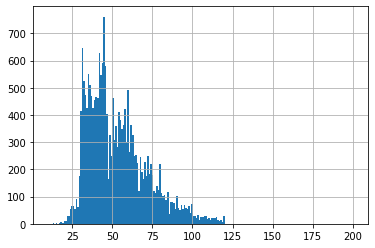

In [12]:
print(df['total_area'].describe())
#df.boxplot(column='total_area')
#plt.show()
df['total_area'].hist(bins=200, range=(10, 200))

Посмотрел графики и примеры из ссылок, но как-то совсем не разобрался как это можно применить к моей гистограмме.
У hist есть такие вот переменные (column=None, by=None, grid=True, xlabelsize=None, xrot=None, ylabelsize=None, yrot=None, ax=None, sharex=False, sharey=False, figsize=None, layout=None, bins=10, backend=None, legend=False), но тут нет названия.
Получается мне надо строить график не через pd  а через plt?

На гистограмме жилой площади видно, что преобладают площади в диапазонах 15-20, 25-45 кв метров, после чего количество наблюдений уменьшается. Среднее значение 34,4, медиана 42,3. Границы выбросов -16,95 и 77,85.

count    19528.000000
mean        30.350286
std         13.056500
min          2.000000
25%         18.000000
50%         29.000000
75%         39.200000
max        100.000000
Name: living_area, dtype: float64


<AxesSubplot:>

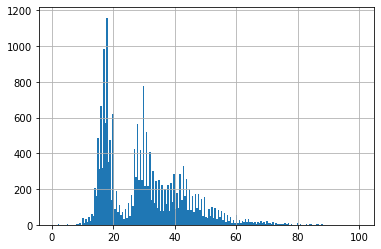

In [13]:
print(df['living_area'].describe())
df['living_area'].hist(bins=200, range=(1, 100))

Средняя площадь кухни составляет 10.5 метров. Большинство наблюдений приходится на 7-12 метров. Выбросы в пределах -0,5 до 19,5  

count    19154.000000
mean         9.688579
std          4.029247
min          1.300000
25%          7.000000
50%          9.000000
75%         11.000000
max         64.000000
Name: kitchen_area, dtype: float64


<AxesSubplot:>

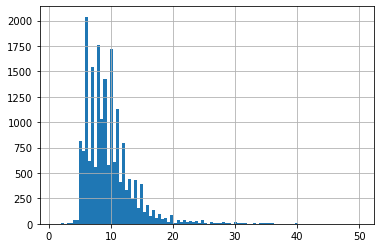

In [14]:
print(df['kitchen_area'].describe())
df['kitchen_area'].hist(bins=100, range=(1, 50))

Да гистограмме видно, что чем дороже квартира, тем хуже её покупают и соответственно меньше их количество. Основная группа наблюдений в диапазоне 3,4 млн - 6,8 млн. Если верить учебнику, то выбросы будем считать от 0 до 10,2 млн.

count       21229.0
mean      4960050.2
std       2569861.3
min         12190.0
25%       3300000.0
50%       4400000.0
75%       5990000.0
max      16000000.0
Name: last_price, dtype: object


<AxesSubplot:>

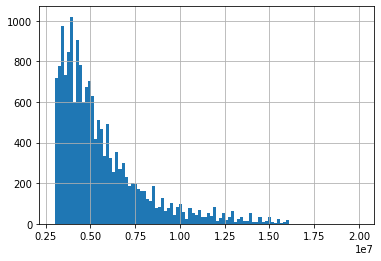

In [15]:
print(df['last_price'].describe().apply("{0:.1f}".format))
df['last_price'].hist(bins=100, range=(3000000, 20000000))

count    21229.000000
mean         1.921899
std          0.894641
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: rooms, dtype: float64


<AxesSubplot:>

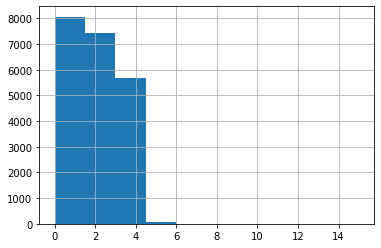

In [16]:
print(df['rooms'].describe())
df['rooms'].hist(bins=10, range=(0, 15))

Средняя высота потолко составляет 2,7 метра, хотя есть те, у кого всего 1 метр. Основное количество наблюдений от 2,5 до 2,8 метров. Выбросы - меньше 2,2 и больше 3,1.

count    12502.000000
mean         2.645512
std          0.147627
min          2.000000
25%          2.500000
50%          2.600000
75%          2.750000
max          3.000000
Name: ceiling_height, dtype: float64


<AxesSubplot:>

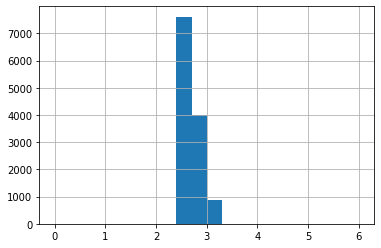

In [17]:
print(df['ceiling_height'].describe())
df['ceiling_height'].hist(bins=20, range=(0, 6))

В среднем для Питера люди покупают квартиры на 5-6 этажах. Основная совокупность наблюдений от 2 до 8 этажа. Выбросы - менее -4(0) и более 14.

count    21229.000000
mean         6.011447
std          4.946093
min          1.000000
25%          2.000000
50%          5.000000
75%          8.000000
max         27.000000
Name: floor, dtype: float64


<AxesSubplot:>

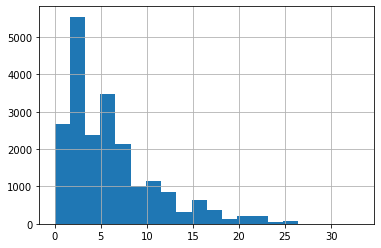

In [18]:
print(df['floor'].describe())
df['floor'].hist(bins=20, range=(0, 33))

В основном люди покупают квартиры между первым и последним этажами, таких 73%. Любителей последнего эатаж 14% и 12% первого.

0.7391304347826086
0.12628950963304914
0.13458005558434216


<AxesSubplot:>

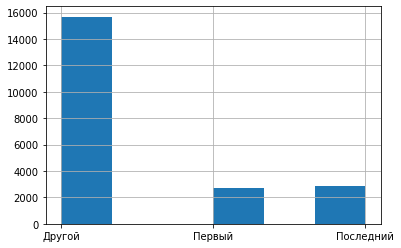

In [19]:
print(len(df.query('floor_type == "Другой"')) / len(df))
print(len(df.query('floor_type == "Первый"')) / len(df))
print(len(df.query('floor_type == "Последний"')) / len(df))
df['floor_type'].hist(bins=6)

В среднем в Питере 10 этажные дома. Основная совокупность наблюдений от 5 до 16. Есть небоскреб на 60 этажей. Выбросы менее -6(0) и более 27. 

count    21229.000000
mean        10.956899
std          6.630165
min          0.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         29.000000
Name: floors_total, dtype: float64


<AxesSubplot:>

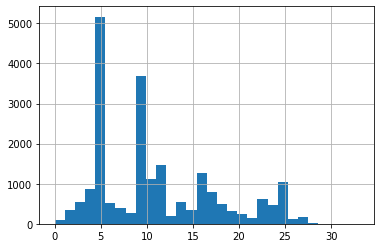

In [20]:
print(df['floors_total'].describe())
df['floors_total'].hist(bins=30, range=(0, 33))

В основном люди живут от центра на расстоянии 14 км. Самая близкая квартира всего в 181 метре от центра. Основная совокупность наблюдений от 9,2 до 16,2 км от центра.

count    15805.000000
mean     15153.074407
std       8329.238362
min        399.000000
25%      10890.000000
50%      13729.000000
75%      16715.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64


<AxesSubplot:>

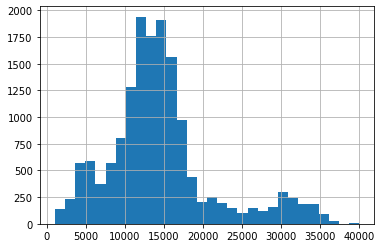

In [21]:
print(df['cityCenters_nearest'].describe())
df['cityCenters_nearest'].hist(bins=30, range=(1000, 40000))

Среднее расстояние до аэропорта составляет 28 км. Основная совокупность наблюдений в диапазоне от 18,5 до 37,2 км.  

count    15790.000000
mean     29113.335782
std      13084.435189
min          0.000000
25%      17892.000000
50%      27687.000000
75%      38305.750000
max      84869.000000
Name: airports_nearest, dtype: float64


<AxesSubplot:>

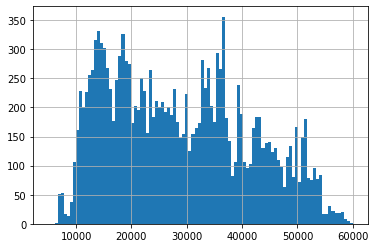

In [22]:
print(df['airports_nearest'].describe())
df['airports_nearest'].hist(bins=100, range=(5000, 60000))

Из диаграммы видно что большинство людей живет в диапазоне от 288 до 612 метров до парка. Кто-то живет через дорогу (мин 1 метр). Среднее значение 490 метров.

count    6428.000000
mean      500.978687
std       343.205245
min         1.000000
25%       300.000000
50%       463.000000
75%       621.000000
max      3190.000000
Name: parks_nearest, dtype: float64


<AxesSubplot:>

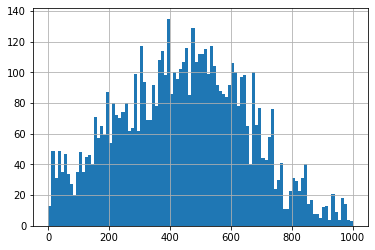

In [23]:
print(df['parks_nearest'].describe())
df['parks_nearest'].hist(bins=100, range=(1, 1000))

В основном люди склонны публиковать объявления в первых числах месяца, тогда как наиболее популярные месяцы приходятся на конец зимы и первую половину весны.

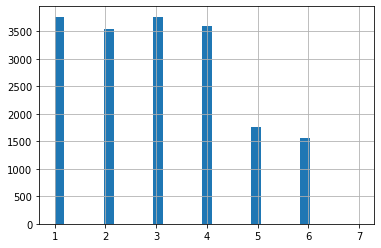

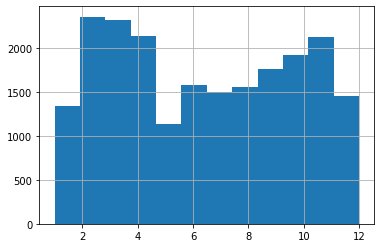

In [24]:
df['weekday_expo'].hist(bins=31, range=(1, 7))
plt.show()
df['month_expo'].hist(bins=12, range=(1, 12))
plt.show()

Переделал. Изменил range на (1,7). Да, тогда вывод такой, что люди публикуют объявления с понедельника по четверг.

В среднем квартиры продаются за полгода, тогда как медианное значение показателя составляет квартал. Такая разница обусловлена тем, что ряд квартир продается очень долгое время, максимальное значение более 4 лет (1580 дней). Быстрыми можно считать продажи менее 45 дней, тогда как необычно долгими будут более 232 дней.

count    18652.000000
mean       171.733487
std        210.066195
min          1.000000
25%         44.000000
50%         91.000000
75%        217.000000
max       1580.000000
Name: days_exposition, dtype: float64


<AxesSubplot:>

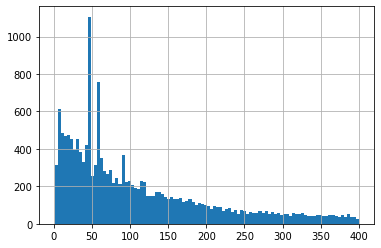

In [25]:
print(df['days_exposition'].describe())
df['days_exposition'].hist(bins=100, range=(1, 400))

Для расчета корреляции буду использовать срез данных по значениям ящика с усами показателя - стоимость квартиры в городе Санкт-Петербург, так как в данном населенном пункте больше всего объектов для наблюдения и корреляцию правильнее строить для каждого населенного пункта отдельно. В рамках обучения пусть это будет Питер. Таким образом в исследуемую совокупность попадут значения от 2,1 млн (4,2 * 0,5) до 12,24 млн (8,16 * 1,5), всё остальное буду считать аномалиями.

1. Корреляция цены и общей площади довольно высокая - 80%, можно сказать, что это основной показатель определяющий стоимость квартиры в Питере.
2. Вторым по значимости идет размер жилой площади, где корреляция 67%.
3. Количество комнат и размер кухни последний фактор определяющий размер стоимсоти квартиры (корр 52 и 53 соответственно).
4. Корреляцию по типу этажа не смог посчитать и не уверен, что правильно посчитал корреляцию по датам размещения.
5. Корреляций по датам размещения нет совсем.

In [26]:
data_for_analysis = df.query('locality_name == "Санкт-Петербург"') #сделал срез
print(data_for_analysis['last_price'].describe().apply("{0:.1f}".format)) #определяем аномалии и выбросы по Q1-Q3
good_data = data_for_analysis.query('2100000 <= last_price <= 12240000')

print(good_data['last_price'].corr(good_data['total_area'])) #корреляция для общей площади
print(good_data['last_price'].corr(good_data['living_area']))
print(good_data['last_price'].corr(good_data['kitchen_area']))
print(good_data['last_price'].corr(good_data['rooms']))
#print(good_data['last_price'].corr(good_data['floor_type'])) 
print(good_data['last_price'].corr(good_data['weekday_expo']))
print(good_data['last_price'].corr(good_data['month_expo']))
print(good_data['last_price'].corr(good_data['year_expo']))



count       13449.0
mean      5866310.4
std       2573741.1
min         12190.0
25%       4050000.0
50%       5100000.0
75%       6900000.0
max      16000000.0
Name: last_price, dtype: object
0.7963582444601752
0.6467857885279472
0.5390598446765783
0.4997817926401993
-0.002431285491352795
-0.0026862513100680283
0.023563684418881754


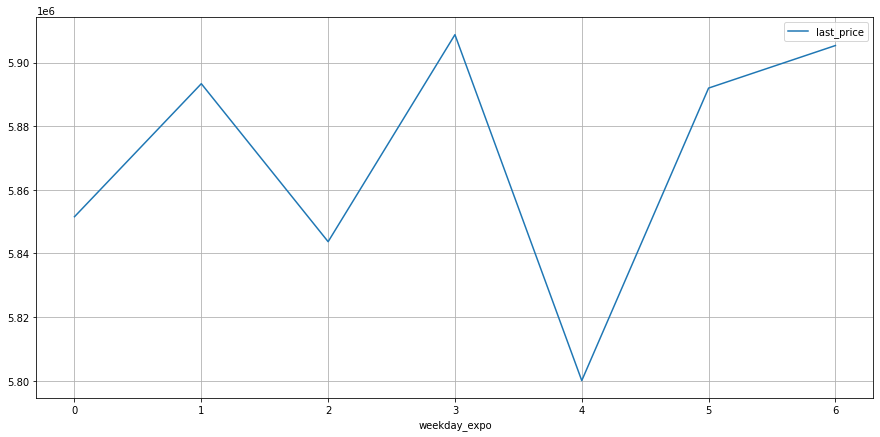

In [27]:
weekday_plot = df.query('locality_name == "Санкт-Петербург"')
weekday_stat = weekday_plot.pivot_table(index='weekday_expo', values='last_price')
weekday_stat.plot(grid=True, figsize=(15,7));

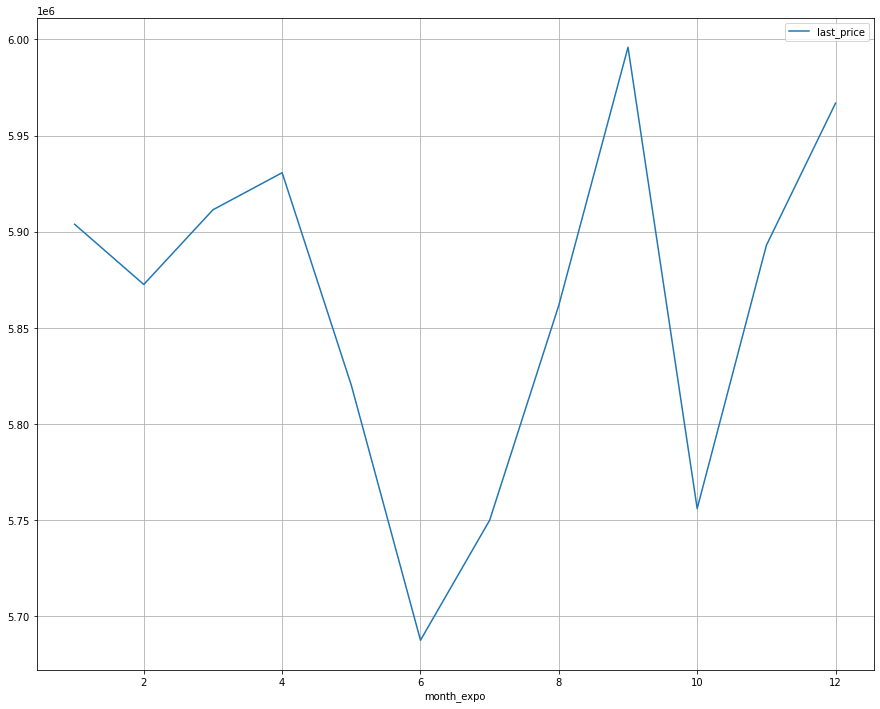

In [28]:
month_plot = df.query('locality_name == "Санкт-Петербург"')
month_stat = month_plot.pivot_table(index='month_expo', values='last_price')
month_stat.plot(grid=True, figsize=(15,12));

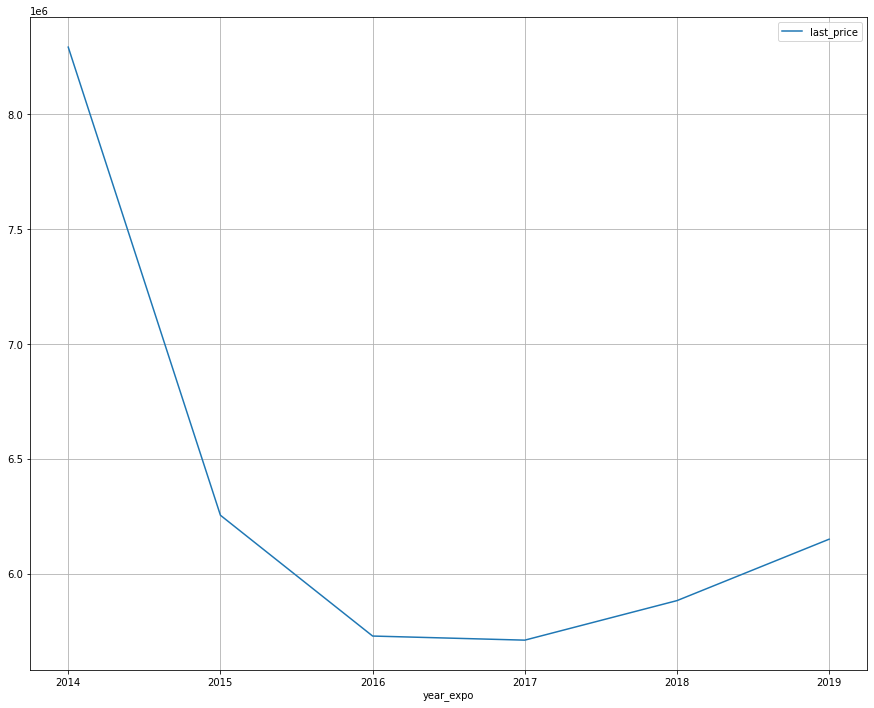

In [29]:
year_plot = df.query('locality_name == "Санкт-Петербург"')
year_stat = year_plot.pivot_table(index='year_expo', values='last_price')
year_stat.plot(grid=True, figsize=(15,12));

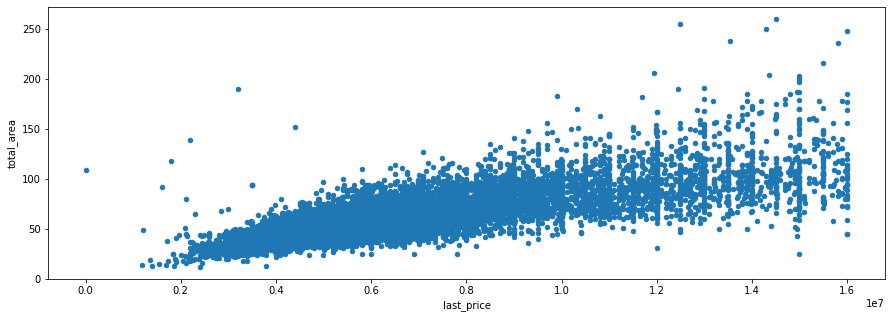

In [30]:
data_price_stat = data_price.query('locality_name == "Санкт-Петербург"')
data_price_stat.plot(x='last_price', y='total_area', kind='scatter', figsize=(15,5));
#сделал точечный график, но не могу понять что он нам показывает. Похоже что чем больше площадь,
#тем больше цена, но мне кажется график не очень информативен.

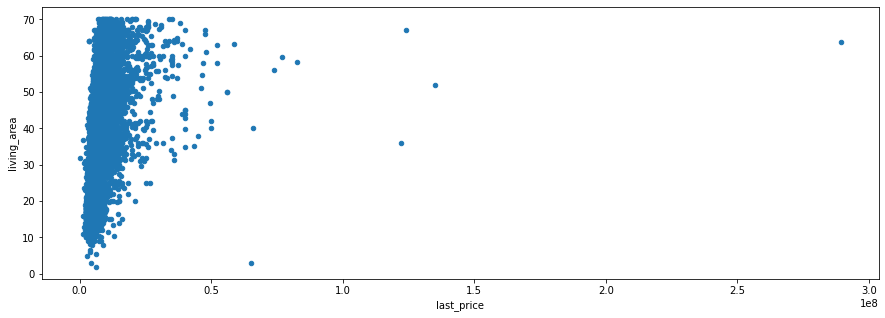

In [31]:
data_living_stat = data_living_area.query('locality_name == "Санкт-Петербург"')
data_living_stat.plot(x='last_price', y='living_area', kind='scatter', figsize=(15,5));

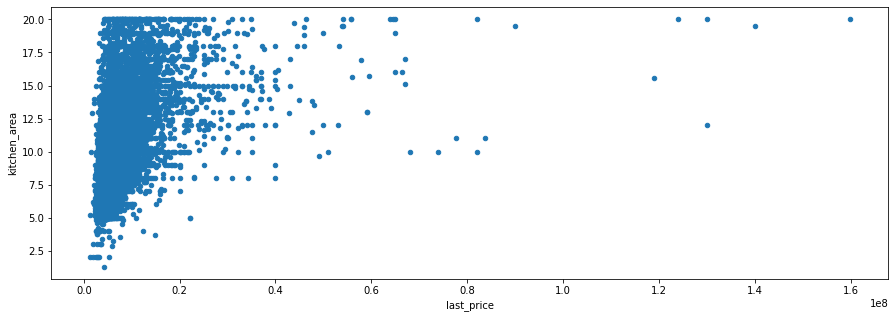

In [32]:
data_kitchen_stat = data_kitchen_area.query('locality_name == "Санкт-Петербург"')
data_kitchen_stat.plot(x='last_price', y='kitchen_area', kind='scatter', figsize=(15,5));

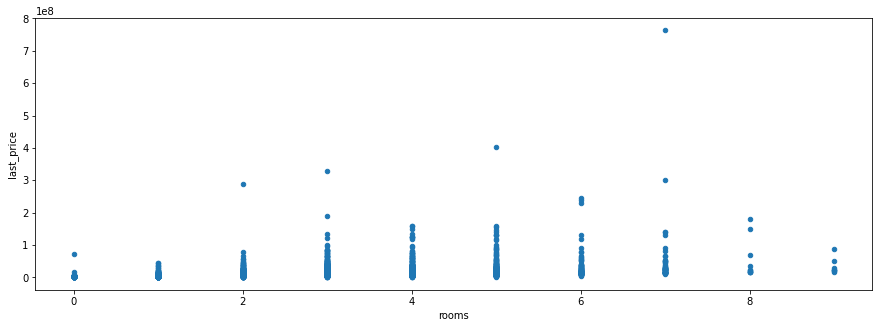

In [33]:
data_rooms_stat = data_rooms.query('locality_name == "Санкт-Петербург"')
data_rooms_stat.plot(x='rooms', y='last_price', kind='scatter', figsize=(15,5));

              last_price
floor_type              
Другой      5.647987e+06
Первый      5.040041e+06
Последний   5.492662e+06


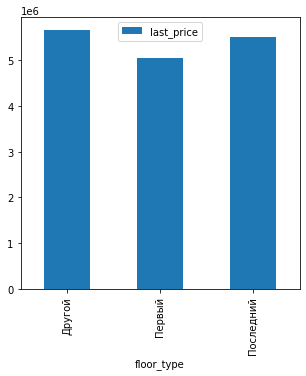

In [34]:
floor_type_stat = good_data.pivot_table(index='floor_type', values='last_price', aggfunc='mean')
print(floor_type_stat)
floor_type_stat.plot(kind='bar', figsize=(5,5));

Самый дорогой квадратный метр в городе Санкт-Петербург - 114 тыс. и Пушкин - 103 тыс.
Самый дешевый в Всеволжске - 68 тыс и Выборге - 58 тыс.

                    last_price  price_per_meter  quantity  total_area
locality_name                                                        
Санкт-Петербург    78896008814    107196.920068     13449   739195.67
Пушкин              1818271964    101178.231231       333    17912.38
деревня Кудрово     1266013220     92473.086957       299    13924.95
поселок Парголово   1459700459     90331.840491       326    16646.00
поселок Мурино      2030712930     85681.305755       556    24442.54
поселок Шушары      1791548999     78643.367580       438    23493.36
Колпино             1240569246     75412.843558       326    16761.34
Гатчина             1025440360     68807.060201       299    14894.18
Всеволожск          1439236065     67152.815385       390    21594.31


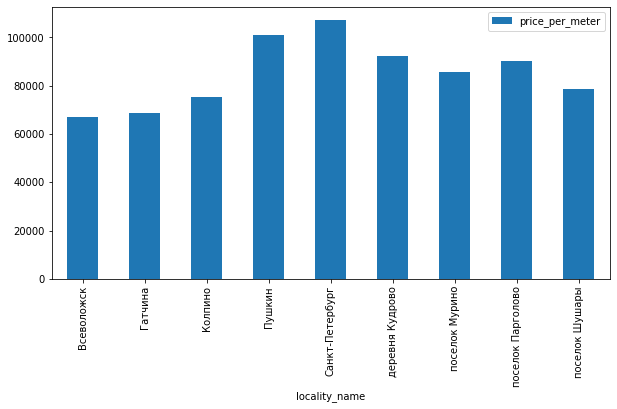

In [35]:
df['quantity'] = 1
data_stat = df.pivot_table(
    index='locality_name',
    values=['price_per_meter', 'quantity', 'last_price', 'total_area'],
    aggfunc={'price_per_meter': 'mean', 'quantity': 'count', 'last_price': 'sum', 'total_area': 'sum'})
#print(data_stat.sort_values(by='quantity', ascending=False).head(10))

top_data_stat = data_stat.query('quantity >= 237')
print(top_data_stat.sort_values(by='price_per_meter', ascending=False))
top_data_stat.plot(kind='bar', y='price_per_meter', figsize=(10,5));

В Питере средняя цена за 1 км составляет 1519 рублей.
Корреляция цены от расстояния до центра составляет 62%, можно сказать, что чем ближе к центру, тем более высокая наценка.

In [36]:
# check
data_for_analysis['price_per_km'] = (data_for_analysis['last_price'] / data_for_analysis['km_to_citycenter'])

/tmp/ipykernel_840/4234432540.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_analysis['price_per_km'] = (data_for_analysis['last_price'] / data_for_analysis['km_to_citycenter'])


In [37]:
avrg_price_per_km = data_for_analysis['price_per_km'].mean()
print(avrg_price_per_km)

print(data_for_analysis['last_price'].corr(data_for_analysis['price_per_km']))


665128.311040539
0.5179116046791858


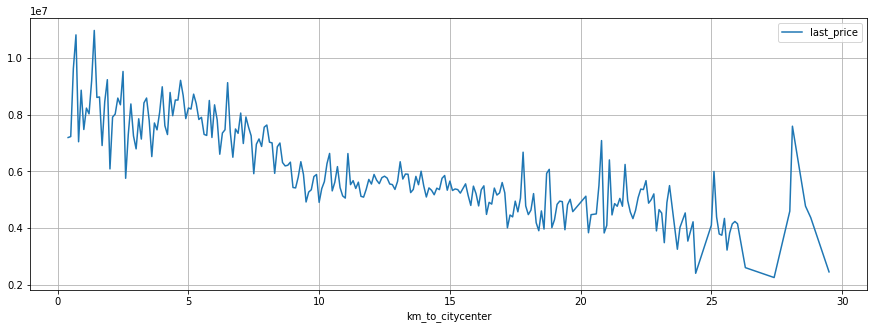

In [38]:
avrg_price_per_km = df.query('locality_name == "Санкт-Петербург"')
avrg_price_per_km_stat = avrg_price_per_km.pivot_table(index='km_to_citycenter', values='last_price')
avrg_price_per_km_stat.plot(grid=True, figsize=(15,5));

In [39]:
# check
df['km_to_citycenter'] = df['km_to_citycenter'].round()

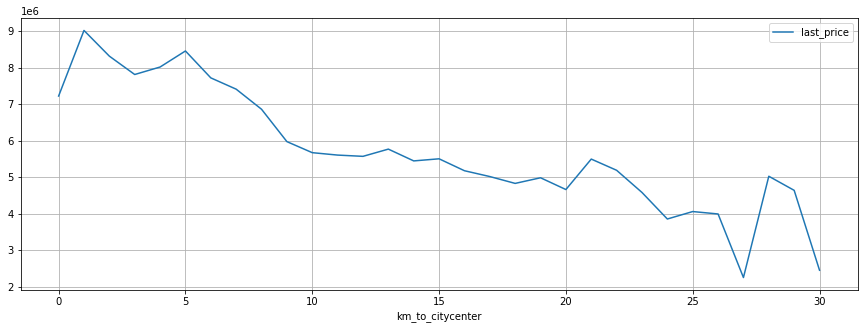

In [40]:
# check
avrg_price_per_km = df.query('locality_name == "Санкт-Петербург"')
avrg_price_per_km_stat = avrg_price_per_km.pivot_table(index='km_to_citycenter', values='last_price')
avrg_price_per_km_stat.plot(grid=True, figsize=(15,5));

### Общий вывод

Задачей было выполнить предобработку данных и изучить их, чтобы найти интересные особенности и зависимости, которые существуют на рынке недвижимости.

1. Средняя стоимость квартиры составляет - 6,5 млн рублей. Минимальное значение 12,1 тыс, а максимальное 793 млн рублей.
2. Самое большое количество объявлений в Санкт-Петербурге и Пушкине.
3. Средняя стоимость квадратного метра в Санкт-Петербурге - 114 тыс, в Пушкине - 103 тыс рублей.
4. Самое большое влияние на стоимость квартиры оказывает общая и жилая площади, где больше всего показатель корреляции.